# Feathering (combination) tests

In [20]:
# ipython notebook setup:
%matplotlib inline

In [21]:
import image_registration
from astropy import convolution
import numpy as np
import pylab as pl
from uvcombine.uvcombine import feather_kernel, fftmerge

In [22]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
np.random.seed(0)
im = image_registration.tests.make_extended(imsize=256., powerlaw=1.5)

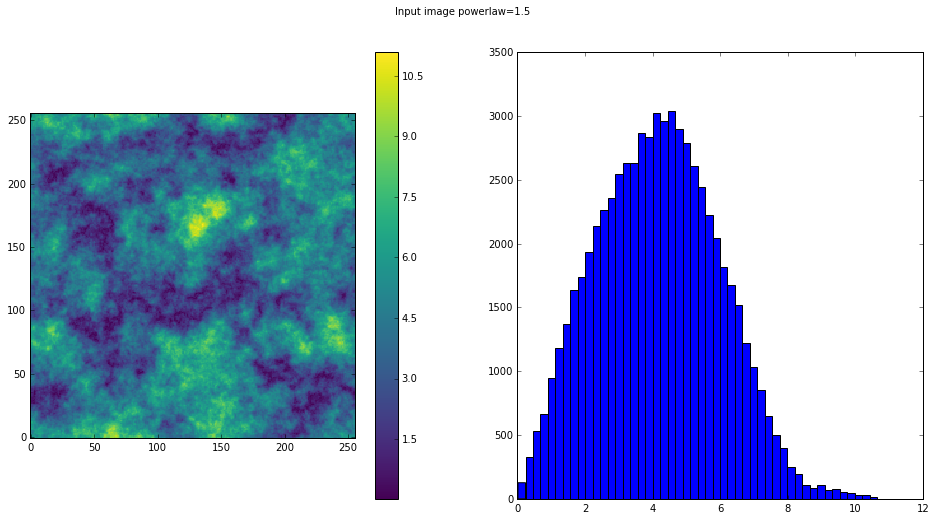

In [26]:
# for each step, we'll save a figure
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.subplot(1,2,2)
pl.hist(im.ravel(), bins=50)
pl.suptitle("Input image powerlaw=1.5")
pl.savefig("inputimage_pl1.5.png")

In [27]:
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

In [29]:
# Create a UV sampling mask.
# This removes all large-angular scale (r<8) features *in UV space* and all
# small angular scales.
# In fourier space, r=0 corresponds to the DC component
# r=1 corresponds to the full map, 256"...? (one period over that map)
# r=128 is the smallest angular scale, which is 2" (nyquist sampling....?)
# That would make r=8 -> 32"...
# I'm not sure that is right, I have to come back to it.
ring = (rr>=8) & (rr<=(256/3.))

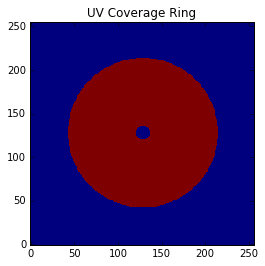

In [30]:
pl.clf()
pl.imshow(ring)
pl.title("UV Coverage Ring")
pl.savefig("uvcoverage_ring.png")

In [31]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

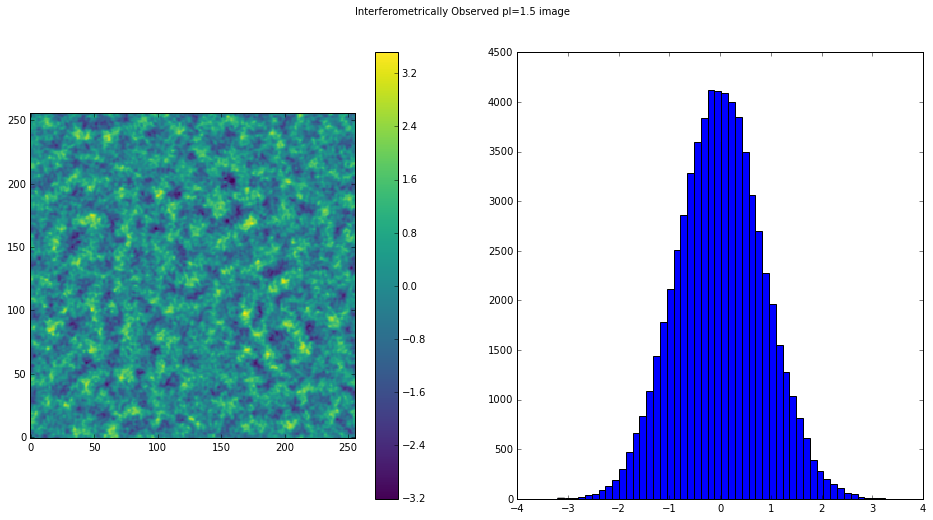

In [44]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im_interferometered.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Interferometrically Observed pl=1.5 image")
pl.subplot(1,2,2)
pl.hist(im_interferometered.real.ravel(), bins=50)
pl.savefig("interf_image_pl1.5.png")

In [33]:
# create the single-dish map by convolving the image with a FWHM=40" kernel
# (this interpretation is much easier than the sharp-edged stuff in fourier
# space because the kernel is created in real space)
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(40/2.35),
                                         boundary='fill', fill_value=im.mean())

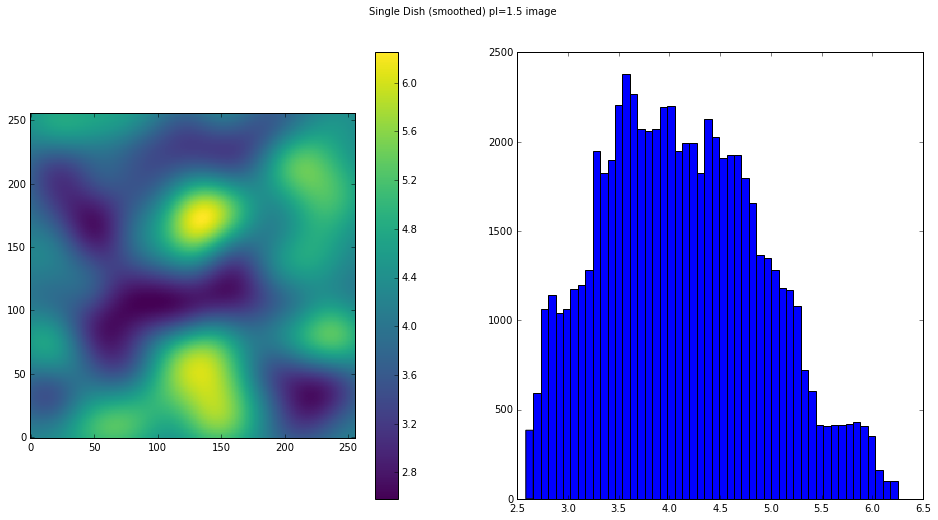

In [45]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(singledish_im, cmap='viridis')
pl.colorbar()
pl.subplot(1,2,2)
pl.hist(singledish_im.ravel(), bins=50)
pl.suptitle("Single Dish (smoothed) pl=1.5 image")
pl.savefig("singledish_image_pl1.5.png")

In [37]:
singledish_kernel = convolution.Gaussian2DKernel(40/2.35, x_size=256, y_size=256)
singledish_kernel_fft = np.fft.fft2(singledish_kernel)

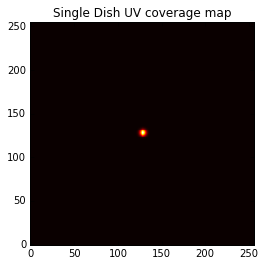

In [39]:
pl.clf()
pl.imshow(np.fft.fftshift(np.abs(singledish_kernel_fft)), cmap='hot')
pl.title("Single Dish UV coverage map")
pl.savefig("singledish_uvcoverage.png")

In [40]:
# pixel scale can be interpreted as "arcseconds"
# then, fwhm=40 means a beam fwhm of 40"
pixscale = 1
lowresfwhm = 40
nax1,nax2 = im.shape
kfft, ikfft = feather_kernel(nax2, nax1, lowresfwhm, pixscale,)

In [41]:
# Feather the interferometer and single dish data back together
# This uses the naive assumptions that CASA uses
# However, there are a few flags that can be played with.
# None of them do a whole lot, though there are good theoretical
# reasons to attempt them.
im_hi = im_interferometered.real
im_low = singledish_im
lowresscalefactor=1
replace_hires = False
highpassfilterSD = False
deconvSD = False
highresscalefactor=1
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         highpassfilterSD=highpassfilterSD,
                         deconvSD=deconvSD,
                        )

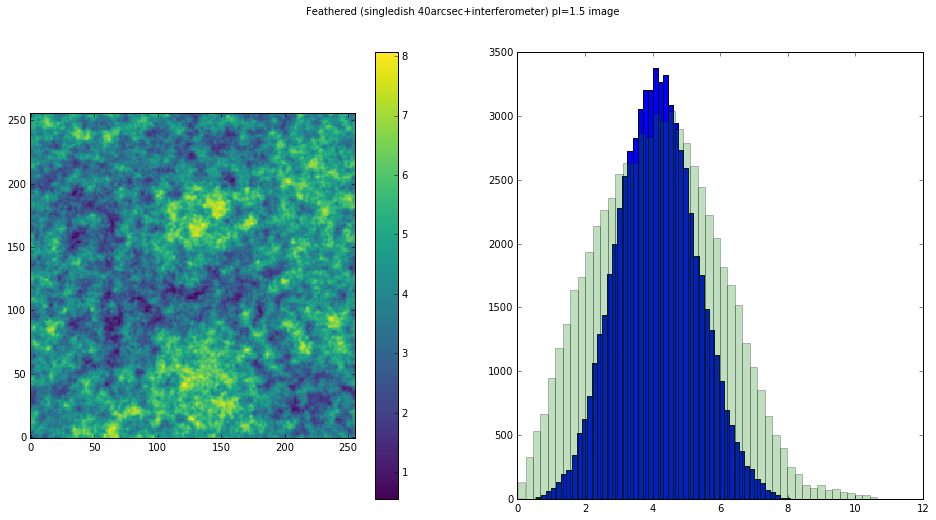

In [48]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.hist(combo.real.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.savefig("feathered_image_pl1.5.png")

The image looks quite unlike the original, and the histogram shows that fluxes are quite poorly recovered all around.

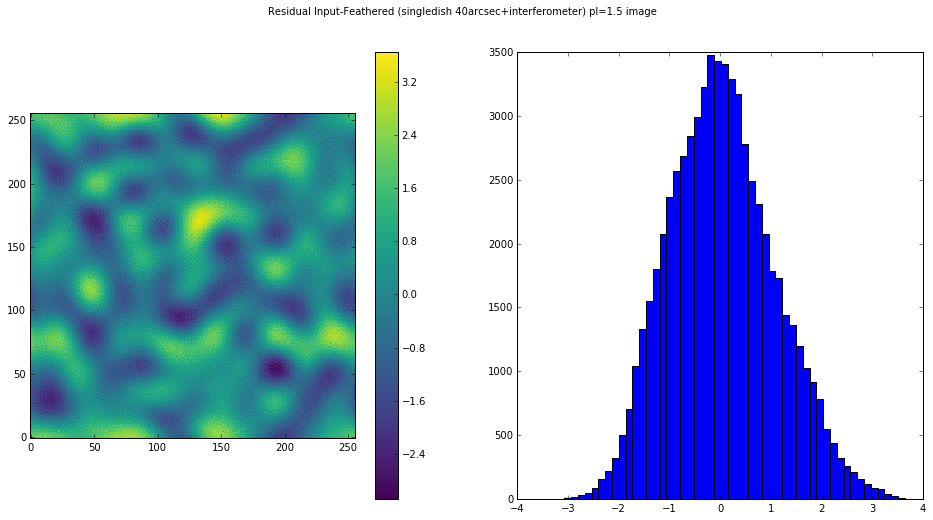

In [47]:
# Residuals (original minus feathered)
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im-combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Residual Input-Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.hist((im-combo.real).ravel(), bins=50)
pl.savefig("residual_feathered_image_pl1.5.png")